#Preparecion del entorno

In [1]:
!pip install pydub

In [49]:
import os
import pathlib

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow_datasets as tfds
import shutil
import random

tf.config.run_functions_eagerly(True)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
data_dir = './data/'

os.makedirs(data_dir, exist_ok=True)

dataset_name = 'spoken_digit'
ds_info = tfds.builder(dataset_name).info

tfds.load(dataset_name, data_dir=data_dir)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling data/spoken_digit/incomplete.52HC3C_1.0.9/spoken_digit-train.tfrecord*...:   0%|          | 0/2500 […

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Dataset spoken_digit downloaded and prepared to ./data/spoken_digit/1.0.9. Subsequent calls will reuse this data.


{Split('train'): <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [5]:
!mv /content/data/downloads/extracted/TAR_GZ.Jako_free-spok-digi-data_arch_v1.0.9i8RM3hKdUFy7trNlwJ-AxmPyqndXivxjTmFBovhxAMA.tar.gz/free-spoken-digit-dataset-1.0.9/recordings/* /content/data/
!rm -rf /content/data/*/

In [6]:
for i in range(10):
    folder_name = os.path.join(data_dir, str(i))
    os.makedirs(folder_name, exist_ok=True)

In [7]:
files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

for filename in files:
    first_char = filename[0]

    destination_dir = os.path.join(data_dir, first_char)
    os.makedirs(destination_dir, exist_ok=True)

    source_path = os.path.join(data_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    shutil.move(source_path, destination_path)

#Preparacion del dataset

Observamos la informacion del dataset

In [8]:
print(ds_info)

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir=PosixGPath('/tmp/tmp74grimhotfds'),
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    su

Cargamos los datos en train y test a partir de las carpetas

In [9]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)

print("label names:", label_names)

train_ds.element_spec

Found 2500 files belonging to 10 classes.
Using 2000 files for training.
Using 500 files for validation.
label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Observamos que disponemos de 2000 archivos de audio para entrenamiento y 500 para validacion todos divididos en 10 clases (numeros del 0 al 9).

Los datos de las labels son numericos.

Comprobamos que el dataset este balanceado.

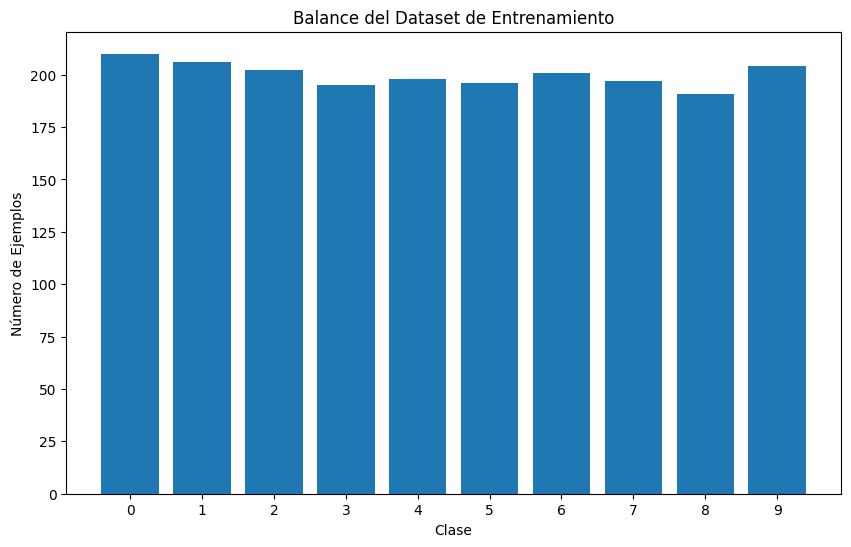

In [63]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

unique, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(label_names[unique], counts)
plt.xlabel('Clase')
plt.ylabel('Número de Ejemplos')
plt.title('Balance del Dataset de Entrenamiento')
plt.show()

Se observa que el dataset esta balanceado pero con variaciones en la cantidad de elementos en cada label.

In [10]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Aplanamos el audio.

In [11]:
example_audio, example_labels = next(iter(train_ds))

print(example_audio.shape)
print(example_labels.shape)

(32, 8000)
(32,)


Observamos el tamaño de los audios y las labels. Corroboramos que tengan la misma longitud y el mismo batch.

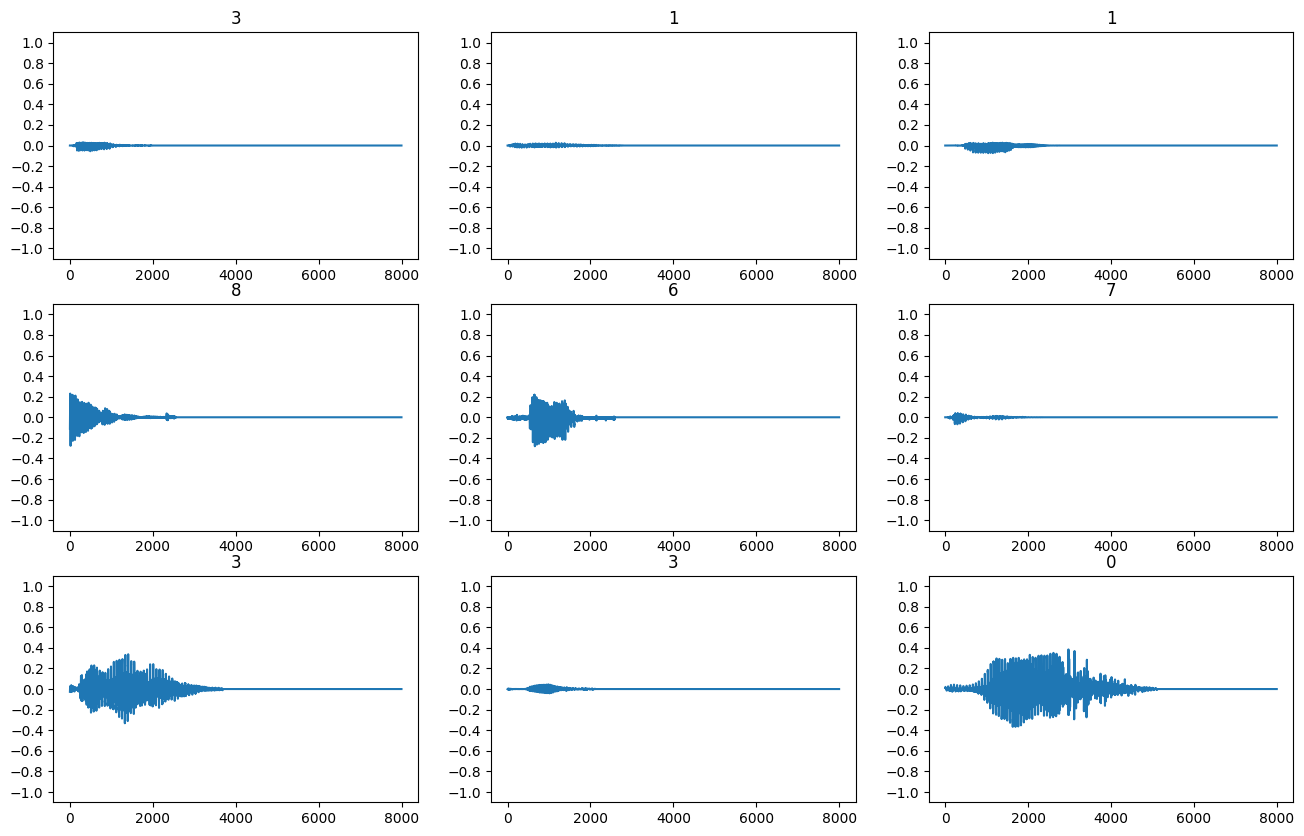

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Realizamos unos gráficos para visualizar los valores del dataset.

In [13]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def plot_audio_and_spectrogram(audio, label):
    spectrogram = get_spectrogram(audio)

    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(audio.shape[0])

    axes[0].plot(timescale, audio.numpy())
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, audio.shape[0]])

    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram')
    axes[1].set_xlim([0, audio.shape[0]])

    plt.suptitle(label.title())
    plt.tight_layout()
    plt.show()

Definimos una funcion para general un espectograma de un audio y las funciones correspondientes para graficorlos junto al audio.

Label: 8
Waveform shape: (8000,)
Audio playback


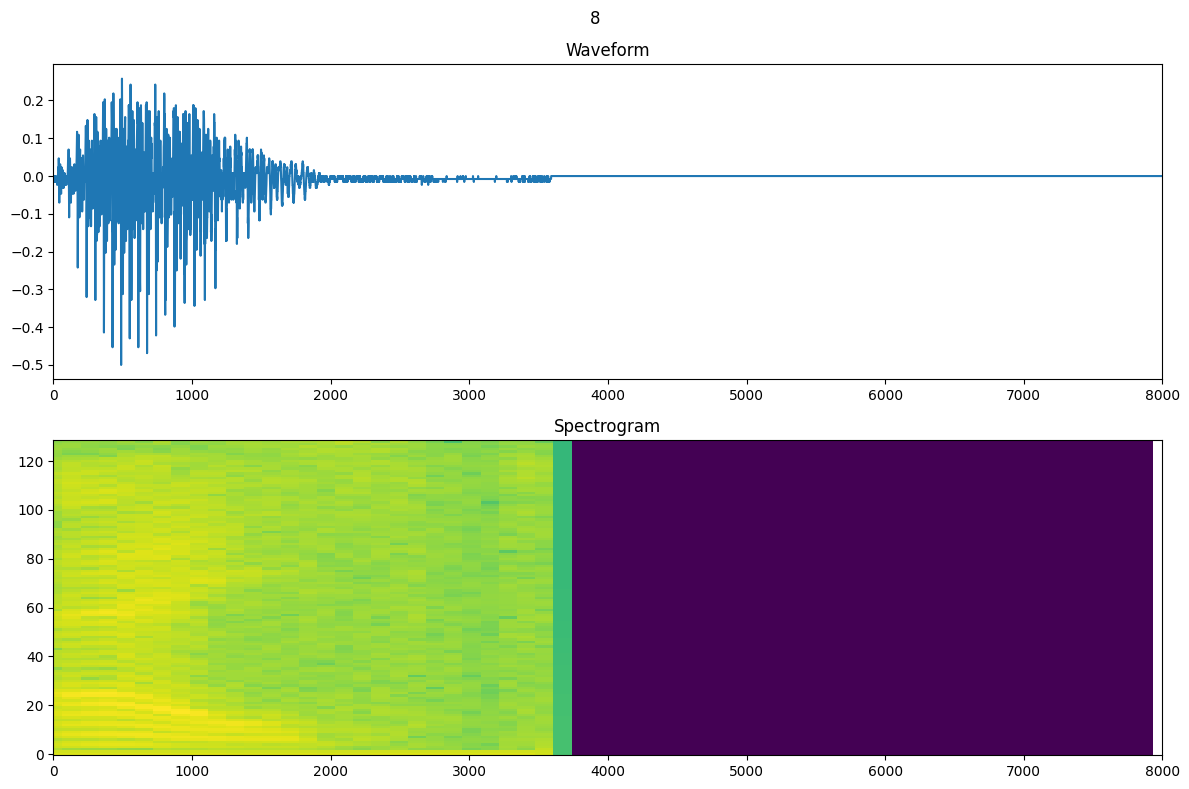

In [14]:
N = 20

label = label_names[example_labels[N]]
waveform = example_audio[N]

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=8000))

plot_audio_and_spectrogram(waveform, label)

Observamos un ejemplo de un audio con su label, shape, valores y espectograma.

In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

Creamos una funcion para generar los dataset con espectogramas a partir de un dataset con audios.

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Generamos el dataframe de entrenamiento y validacion con los espactogramas.

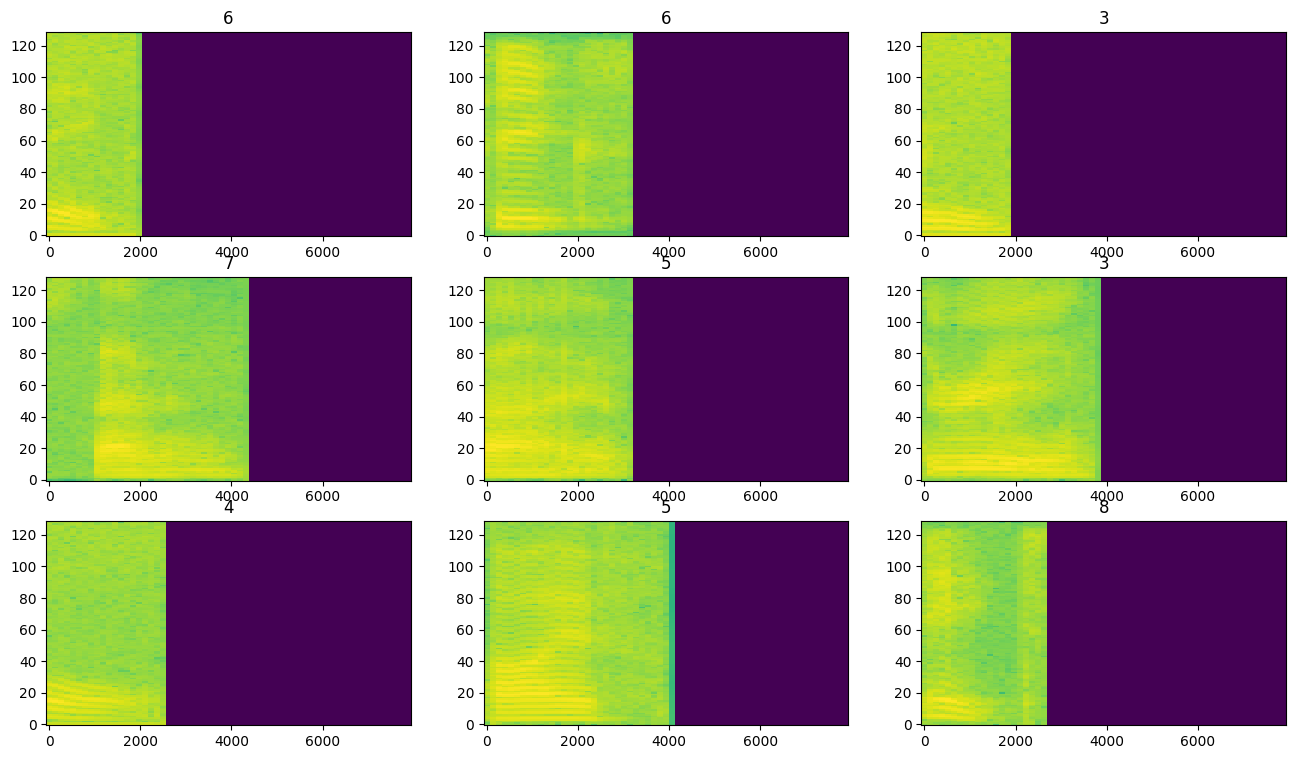

In [17]:
example_spectrograms, example_spect_labels = next(iter(train_spectrogram_ds))

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

#Modelos

##Red neuronal convolucional

Obtenemos la forma de entrada del modelo a partir del shape de los espectrogramas de ejemplo.

In [18]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

Input shape: (61, 129, 1)


Obtenemos el numero de labels para la salida del modelo.

In [19]:
num_labels = len(label_names)
print('Number of labels:', num_labels)

Number of labels: 10


Crea una capa de normalización y la adaptamos a los datos del conjunto de espectrogramas de entrenamiento.


In [20]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Definimos el modelo de la red neuronal convolucional.

In [21]:
model_combolucion = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Visualizamos la estructura del modelo para entender las capas y los parámetros involucrados.

In [22]:
model_combolucion.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Compilamos el modelo.

In [23]:
model_combolucion.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Implementamos early stopping para detener el entrenamiento si la precisión de validación no mejora después de 10 épocas.

In [24]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

Entrenamos el modelo utilizando los datasets de espectrogramas de entrenamiento y validación, durante un máximo de 100 épocas, con early stopping activado para evitar el sobreajuste.

In [25]:
EPOCHS = 100

history_combolucion = model_combolucion.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback]
)

Epoch 1/100
63/63 [==============================] - 9s 67ms/step - loss: 1.6829 - accuracy: 0.4205 - val_loss: 1.1159 - val_accuracy: 0.6880
Epoch 2/100
63/63 [==============================] - 3s 54ms/step - loss: 1.0789 - accuracy: 0.6420 - val_loss: 0.7709 - val_accuracy: 0.8120
Epoch 3/100
63/63 [==============================] - 4s 65ms/step - loss: 0.8227 - accuracy: 0.7370 - val_loss: 0.5758 - val_accuracy: 0.8520
Epoch 4/100
63/63 [==============================] - 3s 54ms/step - loss: 0.6013 - accuracy: 0.8100 - val_loss: 0.4245 - val_accuracy: 0.8860
Epoch 5/100
63/63 [==============================] - 3s 53ms/step - loss: 0.4371 - accuracy: 0.8630 - val_loss: 0.3655 - val_accuracy: 0.9120
Epoch 6/100
63/63 [==============================] - 4s 67ms/step - loss: 0.3426 - accuracy: 0.8970 - val_loss: 0.3073 - val_accuracy: 0.9380
Epoch 7/100
63/63 [==============================] - 3s 53ms/step - loss: 0.3074 - accuracy: 0.8980 - val_loss: 0.3240 - val_accuracy: 0.9220
Epoch 

Visualizamos las curvas de pérdida y precisión durante el entrenamiento y la validación del modelo del modelo.

Text(0, 0.5, 'Accuracy [%]')

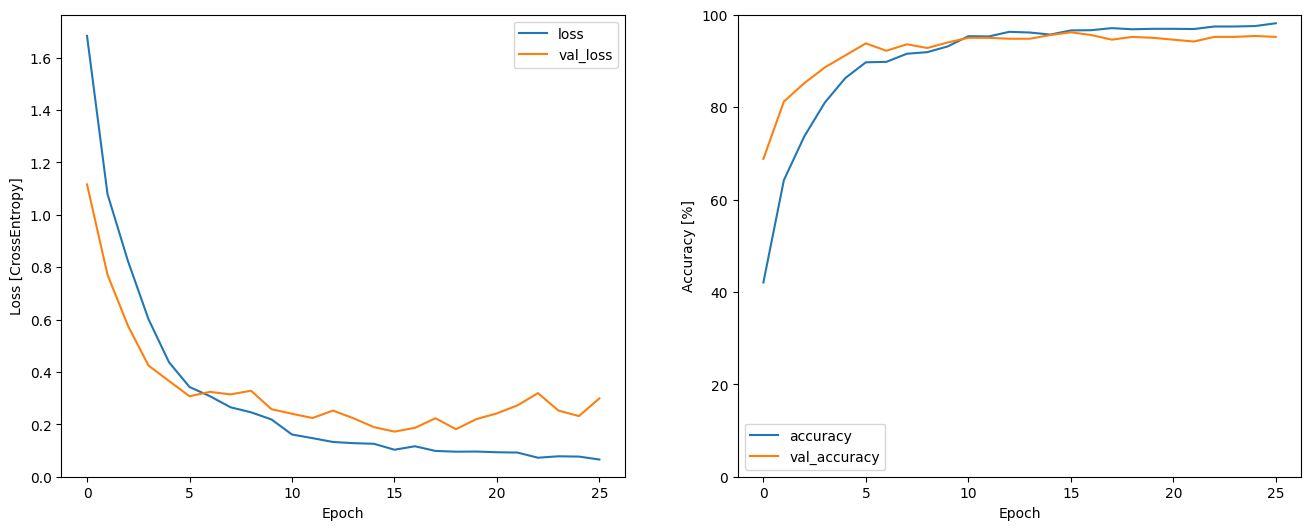

In [26]:
metrics = history_combolucion.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_combolucion.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_combolucion.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Realizamos predicciones utilizando el modelo entrenado y obtenemos las etiquetas predichas.

In [53]:
y_pred_conv = model_combolucion.predict(val_spectrogram_ds)
y_pred_conv = tf.argmax(y_pred_conv, axis=1)

16/16 [==============================] - 0s 12ms/step


Obtenemos las etiquetas verdaderas del conjunto de datos de validación para compararlas con las etiquetas predichas.

In [28]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

Generamos la matriz de confusión del modelo para evaluar el rendimiento.

In [56]:
def metricas(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1 Score: {f1:.4f}')

def plot_confusion_matrix(y_true, y_pred):
  confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx,
              xticklabels=label_names,
              yticklabels=label_names,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

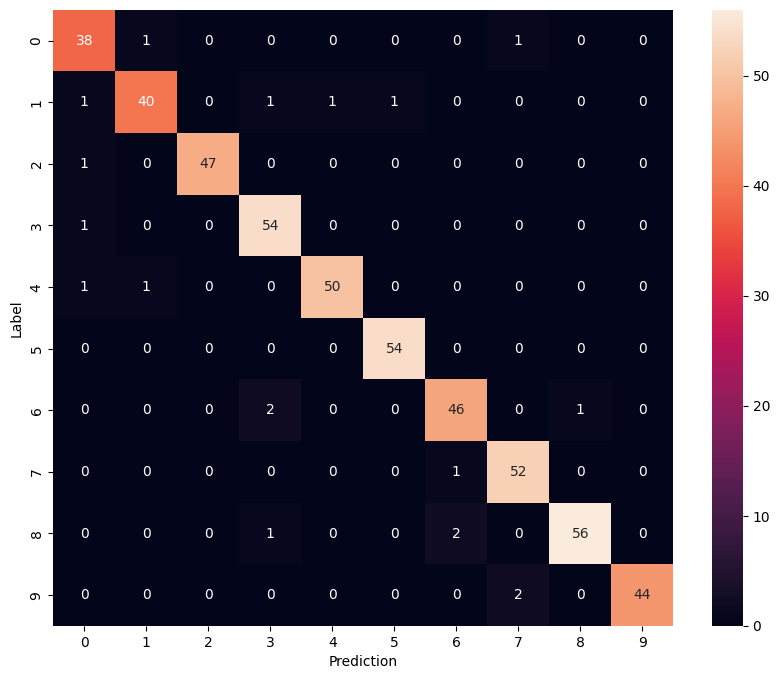

In [54]:
plot_confusion_matrix(y_true, y_pred_conv)

Observamos que el modelo predice correctamente la mayoria de los datos con pocos errores.

In [57]:
metricas(y_true, y_pred_conv)

Accuracy: 0.9620
Precision: 0.9627
Recall: 0.9620
F1 Score: 0.9621


In [30]:
def seleccionar_archivo_aleatorio(carpeta_base):
    subfolders = [f.path for f in os.scandir(carpeta_base) if f.is_dir()]

    random_subfolder = random.choice(subfolders)

    files_in_subfolder = [os.path.join(random_subfolder, f) for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]

    random_file = random.choice(files_in_subfolder)

    subfolder_name = os.path.basename(random_subfolder)

    return random_file, subfolder_name


Realizamos predicciones sobre un ejemplo de audio, mostrando las probabilidades predichas para cada clase y reproduciendo el audio.

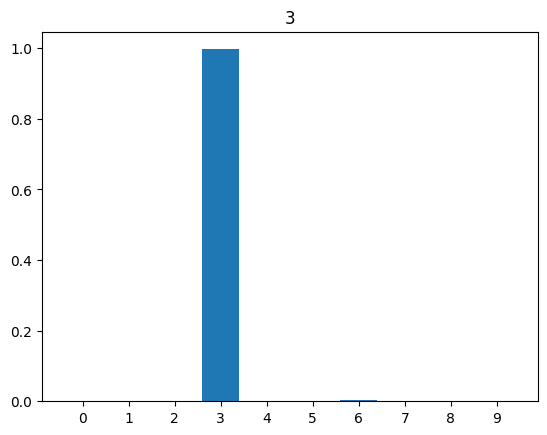

In [34]:
carpeta_base = '/content/data/'
x, label = seleccionar_archivo_aleatorio(carpeta_base)

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_combolucion(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(label)
plt.show()

display.display(display.Audio(waveform, rate=8000))

Observamos un ejemplo cualquiera y vemos la prediccion de la red neuronal.

##Red neuronal recurrente

Observamos las dimensiones de los espectogramas.

In [35]:
print(next(iter(train_spectrogram_ds))[0].shape[1:])

(61, 129, 1)


Obtuvimos que individualmente tienen 61 puntos de tiempo, 129 frecuencias y un canal extra que debemos aplanar.

Definimos el modelo de red neuronal recurrente con una capa LSTM bidireccional para procesar secuencias de entrada.

In [36]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(61, 129, 1)),
    tf.keras.layers.Reshape((61, 129)),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

Mostramos un resumen detallado del modelo

In [37]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 61, 129)           0         
                                                                 
 bidirectional (Bidirection  (None, 128)               99328     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 108234 (422.79 KB)
Trainable params: 108234 (422.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compilamos el modelo especificando el optimizador Adam para el ajuste de pesos,
la función de pérdida de entropía cruzada escasa para problemas de clasificación multiclase y la métrica de precisión para monitorizar el entrenamiento.

In [38]:
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Definimos un callback de EarlyStopping que monitorea la precisión en el conjunto de validación.
Detendrá el entrenamiento después de 10 épocas si no hay mejora en la precisión, restaurando los mejores pesos del modelo.

In [39]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

Entrenamos el modelo con el early stopping definido anteriormente

In [40]:
history_RNN = model_rnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback]
)

Epoch 1/100
63/63 [==============================] - 6s 83ms/step - loss: 1.7042 - accuracy: 0.4940 - val_loss: 0.9840 - val_accuracy: 0.7440
Epoch 2/100
63/63 [==============================] - 5s 74ms/step - loss: 0.6448 - accuracy: 0.7970 - val_loss: 0.5087 - val_accuracy: 0.8340
Epoch 3/100
63/63 [==============================] - 5s 86ms/step - loss: 0.3303 - accuracy: 0.8960 - val_loss: 0.3620 - val_accuracy: 0.8760
Epoch 4/100
63/63 [==============================] - 4s 71ms/step - loss: 0.2444 - accuracy: 0.9275 - val_loss: 0.2422 - val_accuracy: 0.9300
Epoch 5/100
63/63 [==============================] - 5s 78ms/step - loss: 0.1795 - accuracy: 0.9490 - val_loss: 0.1702 - val_accuracy: 0.9440
Epoch 6/100
63/63 [==============================] - 5s 82ms/step - loss: 0.1162 - accuracy: 0.9700 - val_loss: 0.1688 - val_accuracy: 0.9420
Epoch 7/100
63/63 [==============================] - 5s 74ms/step - loss: 0.1656 - accuracy: 0.9485 - val_loss: 0.1486 - val_accuracy: 0.9600
Epoch 

Visualizamos las curvas de pérdida y precisión durante el entrenamiento del modelo RNN, comparando las métricas de entrenamiento con las de validación para evaluar su rendimiento.

Text(0, 0.5, 'Accuracy [%]')

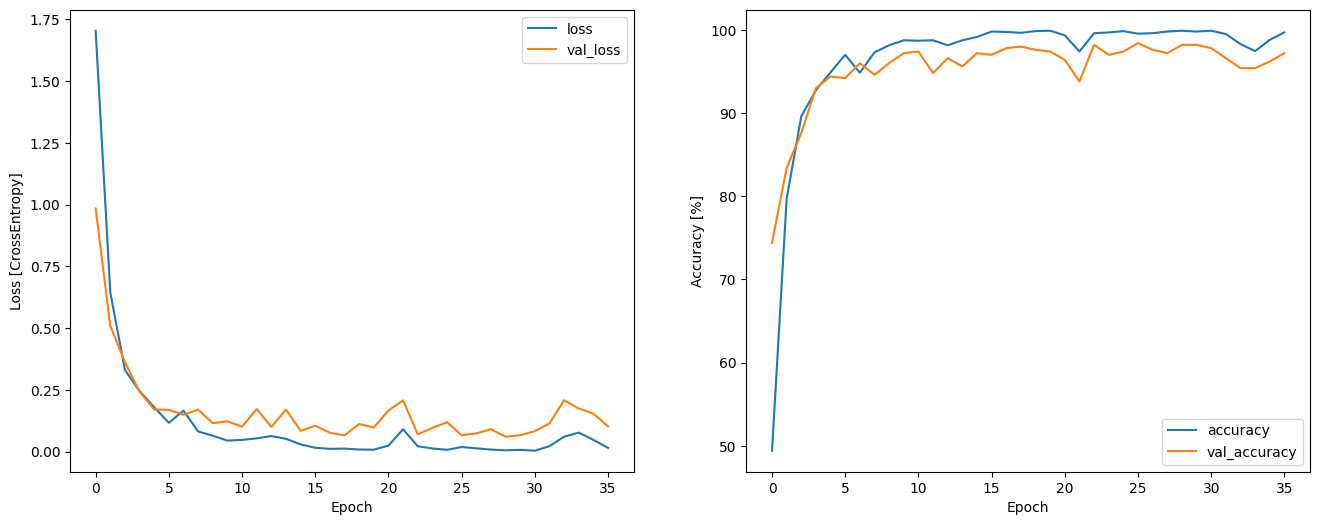

In [41]:
metrics = history_RNN.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_RNN.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_RNN.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Realizamos predicciones utilizando el modelo RNN.

In [42]:
y_pred_rrn = model_rnn.predict(val_spectrogram_ds)
y_pred_rrn = tf.argmax(y_pred_rrn, axis=1)

16/16 [==============================] - 0s 25ms/step


Graficamos la matriz de confusión para evaluar el rendimiento del modelo RNN.

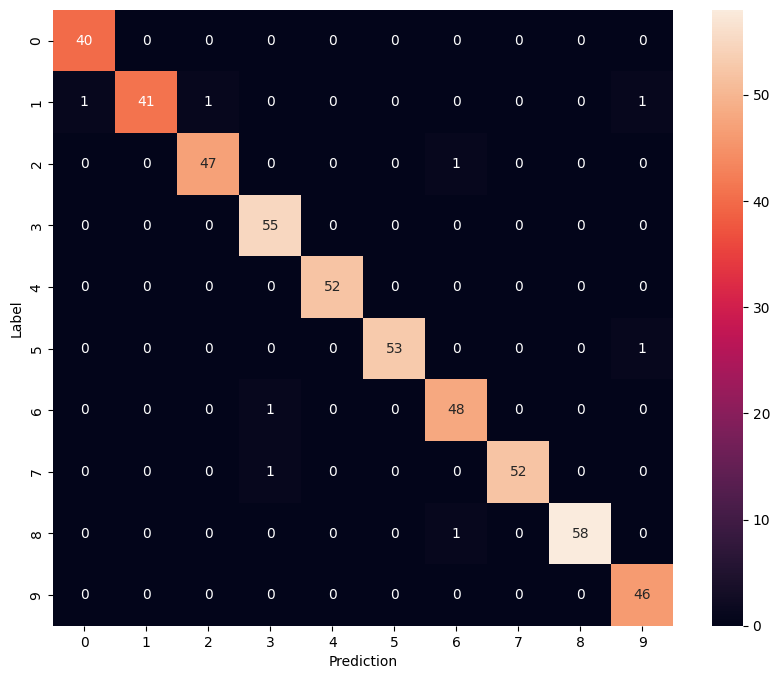

In [58]:
plot_confusion_matrix(y_true, y_pred_rrn)

Observamos que el modelo se comporta muy bien con estos datos, con una leve confusion con los audios de 1 que el modelo de RNN los confunde con 9.

In [59]:
metricas(y_true, y_pred_rrn)

Accuracy: 0.9840
Precision: 0.9844
Recall: 0.9840
F1 Score: 0.9840


Observamos un ejemplo cualquiera y su prediccion.

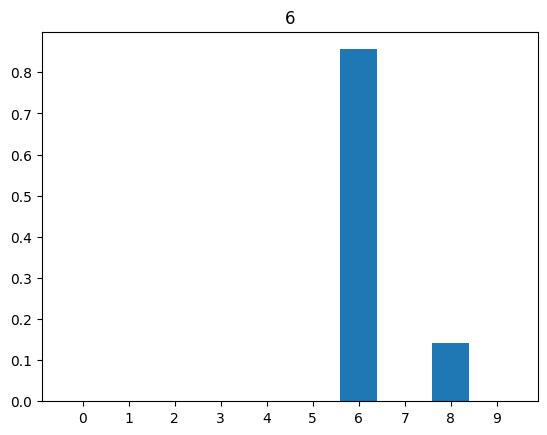

In [48]:
x, label = seleccionar_archivo_aleatorio(carpeta_base)
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_combolucion(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(label)
plt.show()

display.display(display.Audio(waveform, rate=8000))